In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

%config InlineBackend.figure_format = 'svg'
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

In [23]:
# Исходные данные для выполнения ДЗ

a_t=2.6 # Размер танка a
b_t=2.7 # Размер танка b

a=2.3 # Размер САУ a
b=2.2 # Размер САУ b

n_100t=16 # Скорострельность, 1/мин
n_100=15 # Скоростельность, 1/мин
n_152=10 # Скоростельность, 1/мин

PTRK_type='ком' # Тип ПТРК

X_0=3100 # Начальное расстояние
omega_100t=1.7 # Среднее число попаданий, необходимое для поражения целей
omega_100=1.7 # Среднее число попаданий, необходимое для поражения целей
omega_152=1.3 # Среднее число попаданий, необходимое для поражения целей
omega_PTUR=1.2 # Среднее число попаданий, необходимое для поражения целей

V_t=10 # Скорость танка
V_PTUR=270 # Скорость ПТУР
t_0=4 # Время, спустя которое в работу включается Т

ExX_100t=1/800 # Характеристики рассеивания
ExX_100=1/700 # Характеристики рассеивания
ExX_152=1/900 # Характеристики рассеивания
ExX_PTUR=1/1500 # Характеристики рассеивания

# # Исходные данные для выполнения ДЗ

# a_t=3 # Размер танка a
# b_t=2.1 # Размер танка b

# a=2.8 # Размер САУ a
# b=1.9 # Размер САУ b

# n_100t=12 # Скорострельность, 1/мин
# n_100=11 # Скоростельность, 1/мин
# n_152=6 # Скоростельность, 1/мин

# PTRK_type='ком' # Тип ПТРК

# X_0=2000 # Начальное расстояние
# omega_100t=1.8 # Среднее число попаданий, необходимое для поражения целей
# omega_100=1.6 # Среднее число попаданий, необходимое для поражения целей
# omega_152=1.1 # Среднее число попаданий, необходимое для поражения целей
# omega_PTUR=1.2 # Среднее число попаданий, необходимое для поражения целей

# V_t=16 # Скорость танка
# V_PTUR=170 # Скорость ПТУР
# t_0=4 # Время, спустя которое в работу включается Т

# ExX_100t=1/1500 # Характеристики рассеивания
# ExX_100=1/600 # Характеристики рассеивания
# ExX_152=1/1000 # Характеристики рассеивания
# ExX_PTUR=1/2000 # Характеристики рассеивания

In [25]:
def get_F_x(x):
    """
    Функция Лапласса
        Аргументы:
            -x (flaot) - аргумент функции
        Результат:
            -Ф(х) (float) - значение функции Лапласса для аргумента х
    """
    return scipy.stats.norm.cdf(x)-0.5

def get_sigma(x, E_x):
    """
    Среднее квадратическое отклонение в зависимости от дальности
        Аргументы:
            - x (float) - дальность;
            - E_x (float) - характеристика рассеивания;
        Резульат:
            - sigma (float) - значение среднеквадратического отклонения
    """
    return 1.48*E_x*x

def get_P(a,b,E_x,x):
    """
    Вероятность попадания при одном выстреле
        Аргументы:
            - a (float) - размер а;
            - b (float) - размер b;
            - E_x (float) - характеристика рассеивания;
            - x (float) - дальность;
        Результаты:
            - P (float) - вероятность попадания при одном выстреле.
    """
    P=4*get_F_x((b/2)/get_sigma(x,E_x))*get_F_x((a/2)/get_sigma(x,E_x))
    return P

def get_W(a,b,E_x,x,omega):
    return get_P(a,b,E_x,x)/omega

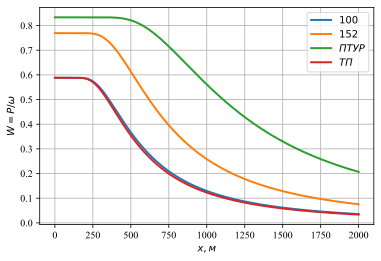

In [26]:
# Графики зависимости вероятности поражения от расстояния

X=np.linspace(0.01, 2e3, 1000)
plt.plot(X, get_W(a_t,b_t,ExX_100,X,omega_100), label='$100$', lw=2)
plt.plot(X, get_W(a_t,b_t,ExX_152,X,omega_152), label='$152$', lw=2)
plt.plot(X, get_W(a_t,b_t,ExX_PTUR,X,omega_PTUR), label='$ПТУР$', lw=2)
plt.plot(X, get_W(a,b,ExX_100t,X,omega_100t), label='$ТП$', lw=2)
plt.xlabel('$x, м$')
plt.ylabel('$W=P/\omega$')
plt.legend(loc='best')
plt.grid()
plt.show()

In [27]:
# Таблица W(P)
x_df=np.linspace(2800,0, round((2800-0)/100+1)) # Массив значений расстояний
sigma_100_df=[]
sigma_152_df=[]
sigma_100t_df=[]
F_a_100_df=[]
F_b_100_df=[]
F_a_152_df=[]
F_b_152_df=[]
F_a_100t_df=[]
F_b_100t_df=[]
W_100_df=[]
W_152_df=[]
W_100t_df=[]

for i in range(len(x_df)):
    if x_df[i]==0:
        x_df[i]=1e-7
    sigma_100_df.append(1.48*ExX_100*x_df[i])
    sigma_152_df.append(1.48*ExX_152*x_df[i])
    sigma_100t_df.append(1.48*ExX_100t*x_df[i])
    F_a_100_df.append(get_F_x(0.5*a_t/(1.48*ExX_100*x_df[i])))
    F_b_100_df.append(get_F_x(0.5*b_t/(1.48*ExX_100*x_df[i])))
    F_a_152_df.append(get_F_x(0.5*a_t/(1.48*ExX_152*x_df[i])))
    F_b_152_df.append(get_F_x(0.5*b_t/(1.48*ExX_152*x_df[i])))
    F_a_100t_df.append(get_F_x(0.5*a/(1.48*ExX_100t*x_df[i])))
    F_b_100t_df.append(get_F_x(0.5*b/(1.48*ExX_100t*x_df[i])))
    W_100_df.append(get_W(a_t,b_t,ExX_100,x_df[i],omega_100))
    W_152_df.append(get_W(a_t,b_t,ExX_152,x_df[i],omega_152))
    W_100t_df.append(get_W(a,b,ExX_100t,x_df[i],omega_100t))

# Запись в таблицу
df_W = pd.DataFrame()
df_W['x,м']=x_df
df_W['sigma_100']=sigma_100_df
df_W['sigma_152']=sigma_152_df
df_W['sigma_100t']=sigma_100t_df
df_W['F_a_100']=F_a_100_df
df_W['F_b_100']=F_b_100_df
df_W['F_a_152']=F_a_152_df
df_W['F_b_152']=F_b_152_df
df_W['F_a_100t']=F_a_100t_df
df_W['F_b_100t']=F_b_100t_df
df_W['W_100']=W_100_df
df_W['W_152']=W_152_df
df_W['W_100t']=W_100t_df

# Отображение таблицы
pd.options.display.float_format = '{:,.3f}'.format
df_W

,"x,м",sigma_100,sigma_152,sigma_100t,F_a_100,F_b_100,F_a_152,F_b_152,F_a_100t,F_b_100t,W_100,W_152,W_100t
0,"2,800.000",5.920,4.604,5.180,0.087,0.090,0.111,0.115,0.088,0.084,0.018,0.039,0.017
1,"2,700.000",5.709,4.440,4.995,0.090,0.093,0.115,0.119,0.091,0.087,0.020,0.042,0.019
2,"2,600.000",5.497,4.276,4.810,0.093,0.097,0.119,0.124,0.094,0.090,0.021,0.046,0.020
3,"2,500.000",5.286,4.111,4.625,0.097,0.101,0.124,0.129,0.098,0.094,0.023,0.049,0.022
4,"2,400.000",5.074,3.947,4.440,0.101,0.105,0.129,0.134,0.102,0.098,0.025,0.053,0.024
5,"2,300.000",4.863,3.782,4.255,0.105,0.109,0.134,0.139,0.107,0.102,0.027,0.058,0.026
6,"2,200.000",4.651,3.618,4.070,0.110,0.114,0.140,0.145,0.111,0.107,0.030,0.063,0.028
7,"2,100.000",4.440,3.453,3.885,0.115,0.119,0.147,0.152,0.116,0.111,0.032,0.069,0.031
8,"2,000.000",4.229,3.289,3.700,0.121,0.125,0.154,0.159,0.122,0.117,0.036,0.075,0.034
9,"1,900.000",4.017,3.124,3.515,0.127,0.132,0.161,0.167,0.128,0.123,0.039,0.083,0.037


In [40]:
# # Дуэль Т и САУ с 100-мм ПТП
def duel(first_par : dict, sec_par : dict):
    # массив времен
    ts = [0]

    # относительная скорость
    V_otn = first_par['V'] + sec_par['V']

    # расстояние
    x = X_0

    # массив кто выстрелил
    who_shot = ['1']

    # моменты времени выстрелов 1 и 2 боевых единиц
    t_tank = 0; t_sau = 4 - 1 / sec_par['n'] * 60

    # W и V с тильдами
    W_tilds = [get_W(first_par['a'],first_par['b'],first_par['E'],x,first_par['omega'])]; V_tilds = [0]

    # W и V
    Ws = [get_W(first_par['a'],first_par['b'],first_par['E'],x,first_par['omega'])]; Vs = [0]

    # произведение 1 - W (или 1 - V)
    WV_minus_1 = 1 - Ws[-1]

    while (W_tilds[-1] + V_tilds[-1] < 1 and x > 0) and len(ts) < 36: #or abs(Ws[-2] - Ws[-1]) / Ws[-1] < 1e-4 or abs(Vs[-2] - Vs[-1]) / Vs[-1] < 1e-4: # боекомплект?
        # время выстрелов
        t_tank += 1 / first_par['n'] * 60
        t_sau += 1 / sec_par['n'] * 60
        
        # выстреливает 1 боевая единица
        if t_tank < t_sau:
            ts.append(t_tank) 
            who_shot.append('1')
            x -= V_otn * ts[-1]
            t_sau -= 1 / sec_par['n'] * 60     # возвращаем время танку
            Ws.append(get_W(first_par['a'],first_par['b'],first_par['E'],x,first_par['omega']))
            W_tilds.append(W_tilds[-1] + WV_minus_1 * Ws[-1])
            WV_minus_1 *= 1 - Ws[-1]
        
        # выстреливает 2 боевая единица
        elif t_tank > t_sau:
            ts.append(t_sau)
            who_shot.append('2')
            x -= V_otn * ts[-1]
            t_tank -= 1 / first_par['n'] * 60   # возвращаем время САУ
            Vs.append(get_W(sec_par['a'],sec_par['b'],sec_par['E'],x,sec_par['omega']))
            V_tilds.append(V_tilds[-1] + WV_minus_1 * Vs[-1])
            WV_minus_1 *= 1 - Vs[-1]

        # выстрелили оба
        else:
            ts.append(t_tank)
            who_shot.append('оба')
            x -= V_otn * ts[-1]
            Ws.append(get_W(first_par['a'],first_par['b'],first_par['E'],x,first_par['omega']))
            Vs.append(get_W(sec_par['a'],sec_par['b'],sec_par['E'],x,sec_par['omega']))
            W_tilds.append(W_tilds[-1] + WV_minus_1 * Ws[-1] * (1 + (1 - Vs[-1]) / 2))
            V_tilds.append(W_tilds[-1] + WV_minus_1 * Vs[-1] * (1 + (1 - Ws[-1]) / 2))
            WV_minus_1 *= (1 - Ws[-1]) * (1 - Vs[-1])

    return {
        't': ts,
        'who': who_shot,
        'W_tild': W_tilds,
        'V_tild': V_tilds
    }



In [41]:
duel({'a': a_t, 'b': b_t, 'E': ExX_100t, 'omega': omega_100t, 'n': n_100t, 'V': V_t}, {'a': a, 'b': b, 'E': ExX_100, 'omega': omega_100, 'n': n_100, 'V': 0})

{'t': [0,
  3.75,
  4.0,
  7.5,
  8.0,
  11.25,
  12.0,
  15.0,
  16.0,
  18.75,
  20.0,
  22.5,
  24.0,
  26.25,
  28.0,
  30.0,
  32.0,
  33.75],
 'who': ['1',
  '1',
  '2',
  '1',
  '2',
  '1',
  '2',
  '1',
  '2',
  '1',
  '2',
  '1',
  '2',
  '1',
  '2',
  '1',
  '2',
  '1'],
 'W_tild': [0.01963084225819494,
  0.0393419336186771,
  0.05992424210520086,
  0.0826148865790218,
  0.1092680860182148,
  0.14320136251015364,
  0.19152948745857565,
  0.27334432416329824,
  0.452348930051493,
  0.5632406916389163],
 'V_tild': [0,
  0.011029381490718427,
  0.02286658946038503,
  0.03633550232037741,
  0.052796207981743316,
  0.07493222569105579,
  0.10926892901023504,
  0.17725186523127318,
  0.3591350752498872]}

In [16]:
# # Посследовательность выстрелов и расстояние от времени

# fig, ax1 = plt.subplots(figsize=(10, 5))
# ax1.plot(t_T_SAU, get_X_tek(t_T_SAU, X_0, V_t), lw=2, color='black', label='$X(t)$')
# ax1.set_xlabel('$t,c$')
# ax1.set_ylabel('$X, м$')
# ax1.grid()
# ax1.legend(loc='lower left')
# ax2 = ax1.twinx()
# ax2.scatter(t_0+t_100ti, np.linspace(0,0, len(t_0+t_100ti)), color='blue', label='$Т$')
# ax2.scatter(t_100i, np.linspace(1,1, len(t_100i)), color='red', marker='^', label='$САУ$')
# ax2.set_yticks([-1,0,1,2]);
# ax2.legend(loc='best');

In [17]:
# df_T_vs_SAU = pd.DataFrame()
# shots=np.linspace(0, 100, 101)
# i=1
# W1=get_W(a_t,b_t,ExX_100,get_X_tek(0, X_0, V_t),omega_100)
# V1=get_W(a,b,ExX_100t,get_X_tek(t_0, X_0, V_t),omega_100t)
# W1_=W1
# V1_=(1-W1)*V1
# Wi_=W1
# Wi_min1_=0
# Vi_=V1_
# Vi_min1_=0
# t_shot_SAU_1=shots[0]*delta_t_100 # время в которое происходит выстрел САУ
# t_shot_t_1=4+shots[0]*delta_t_100
# W_V=['W', 'V']
# n_shots=[1,1]
# t_shots=[t_shot_SAU_1, t_shot_t_1]
# P_array=[(1-W1),(1-W1-V1)]
# Krit_1=[1,1]
# Krit_2=[1,1]
# p=1
# print('Vi_ = ',round(Vi_, 3), 't = ', t_shot_t_1)
# print('Wi_ = ',round(Wi_, 3), 'i = ', t_shot_SAU_1)
# while ((Wi_- Wi_min1_)/Wi_ > 0.01) or ((Vi_- Vi_min1_)/Vi_ > 0.01):
#     t_shot_SAU=shots[i]*delta_t_100 # время в которое происходит выстрел САУ
#     t_shot_t=4+shots[i]*delta_t_100t # время в которое происходит выстрел Т
#     Wi_min1=Wi
#     Vi_min1=Vi
#     Wi=get_W(a_t,b_t,ExX_100,get_X_tek(t_shot_SAU, X_0, V_t),omega_100)
#     Vi=get_W(a,b,ExX_100t,get_X_tek(t_shot_t, X_0, V_t),omega_100t)
#     Wi_min1_=Wi_
#     Wi_=Wi_min1_+p*(1-Wi_min1)*(1-Vi_min1)
#     Vi_min1_=Vi_
#     Wip1=get_W(a_t,b_t,ExX_100,get_X_tek(t_shot_SAU, X_0, V_t),omega_100)
#     Vi_=Vi_min1_+p*(1-Wi_min1)*(1-Vi_min1)*(1-Wi)*Vi
#     p=(1-Wi_min1)*(1-Vi_min1)*p
    
#     print('Vi_ = ',round(Vi_, 3), 't = ', t_shot_t)
#     print('Wi_ = ',round(Wi_, 3), 'i = ', t_shot_SAU)
#     i=i+1

#     # if t_shot_SAU>t_shot_t:
#     #     W_V.append('W')
#     #     n_shots.append()

In [18]:
# Дуэль танка и САУ с 100 мм ПТП

flag = 0
i = 0
N_tank_i = n_t

NameError: name 'n_t' is not defined